# VTOL Take-off Failure Options

Looking at some of the options in terms of engine failure(s) during a vertical take-off of an aircraft like the [Pegasus Vertical Business Jet (VBJ)](https://pegasusua.com/pegasus-vertical-business-jet/).

## Vertical Descent

Initially assume a purely vertical descent after a partial or complete engine failure to determine what the maximum height 
is that the aircraft can descend from and land sucessfully based on the landing gear's rating.

Basic kinematics.

$  s = v_0 + \frac{1}{2}at^2 \tag{1} $

$ v = v_0 + at  \tag{2} $

Assuming $v_0$ is 0 then we can solve for the final velocity when hitting the ground from a starting height of $s$ and ignoring any drag.

$  t = \sqrt{\frac{2s}{a}} \tag{3} $

$ v = a \sqrt{\frac{2s}{a}}  \tag{4} $

Or assuming a maximum $v$ based on gear strength and a known acceleration $a$ we can solve for $s$.

$ s = \frac{v^2}{2a} \tag{5} $

### Total Engine Failure

Now assuming a maximum vertical speed of say 1,000fpm (5.1m/s) in terms of what the landing gear are rated to and assuming a total engine failure, i.e. $ a = g $.

$  s = \frac{5.1^2}{2 \, \times \, 9.81} = 1.3m$

So the aircraft can only handle a total engine failure from 1.3m?

### Partial Engine Failure

For example 1 of the 2 engines failing. Let's assume the thrust to weight ratio with both engines at full thrust is 1.2, so 
a thrust to weight ratio of 0.6 with a single engine failure. So $a = (1 - 0.6)g$ in this case.

$ s = \frac{5.1^2}{2 \, \times \, (1 \,  - \, 0.6) \, \times \, 9.81} = 3.3m $

Calculate and plot the safe height for partial engine failure versus the thrust to weight ratio available after the partial engine failure.

<IPython.core.display.Javascript object>


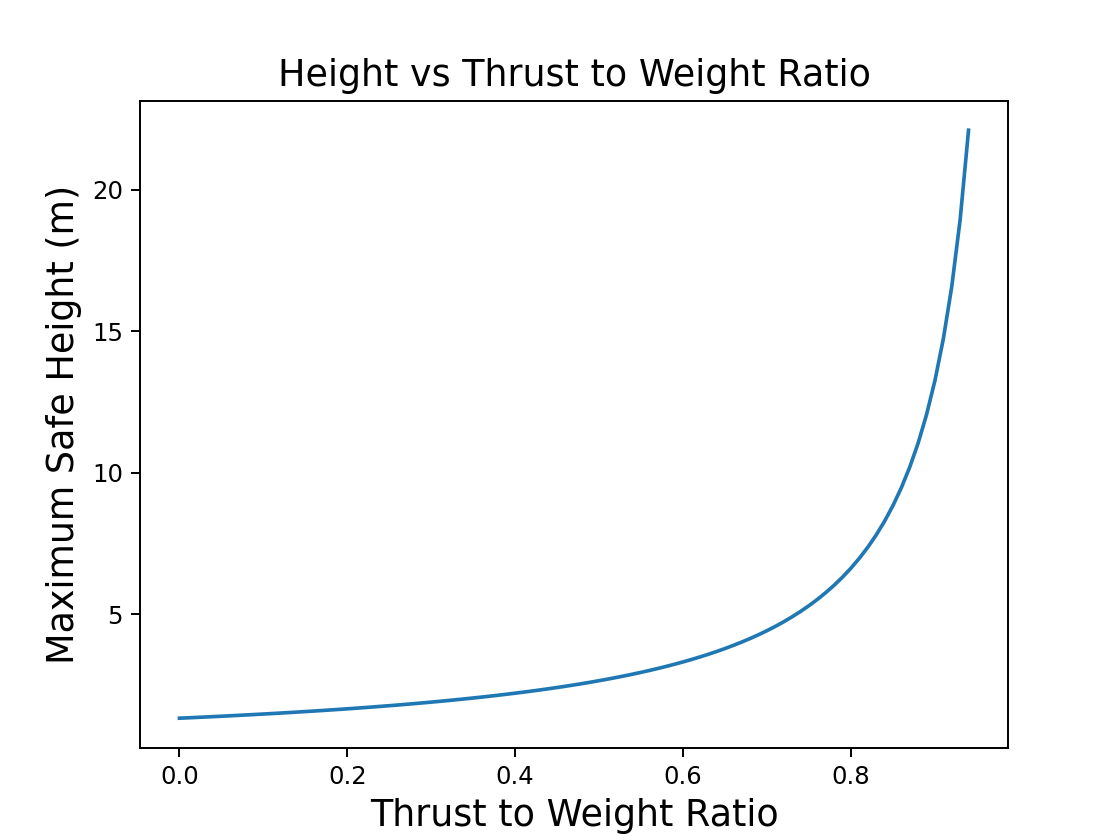

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

maxVS = 5.1    # Maxmimum safe vertical speed in m/s given gear strength rating

thrustToWeight = []
height = []

for a in np.arange(0, 0.95, 0.01):
    s = maxVS**2 / (2 * (1 - a) * 9.81)
    thrustToWeight.append(a)
    height.append(s)
    
plt.figure()
plt.plot(thrustToWeight, height)
plt.xlabel("Thrust to Weight Ratio", fontsize=15)
plt.ylabel("Maximum Safe Height (m)", fontsize=15)
plt.title("Height vs Thrust to Weight Ratio", fontsize=15)
plt.show()